In [ ]:
# default_exp cci

# Storm detection

> finds low pressure systems

In [ ]:
#export
import xarray as xr
import numpy as np
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

In [ ]:
#export
from drcstools.derivative import *
from drcstools.storm import *
from drcstools.helper_functions import *

def stormdetection(stormobj, slpname = "slp", pmax = 100000):
    
    lon = stormobj._get_name_longitude()
    lat = stormobj._get_name_latitude()
    
    stormobj.derivative(slpname, N = 20, dim = lon, order = 1)
    stormobj.derivative(slpname, N = 20, dim = lat, order = 1)
    
    stormobj.derivative(slpname, N = 20, dim = lon, order = 2)
    stormobj.derivative(slpname, N = 20, dim = lat, order = 2)    
    
    stormobj.ds['area_t'] = ((lat, lon), 
                            calculate_area_t(lon = stormobj.ds[lon].values,
                                             lat = stormobj.ds[lat].values))
        
    zero_crossings_x = xr.where(xr.ufuncs.signbit(stormobj.ds["dd{}{}".format(lon, slpname)]).astype(int).diff("lon") != 0, 1, 0)
    zero_crossings_y = xr.where(xr.ufuncs.signbit(stormobj.ds["dd{}{}".format(lat, slpname)]).astype(int).diff("lat") != 0, 1, 0)
    zero_crossings = xr.where((zero_crossings_x == 1) & (zero_crossings_y == 1), 1, 0)
    
    dP = 0.5 * (stormobj.ds["dd{}{}".format(lon, slpname)] + stormobj.ds["dd{}{}".format(lat, slpname)])
    
    Pzonal = dP.mean([stormobj._get_name_time(), lat])

    lows = stormobj.ds[slpname].where(zero_crossings == 1).where(dP - Pzonal < 0)
    dP = dP.where(lows < pmax)
    lows = lows.where(lows < pmax)
    
    stormobj.ds["lows"] = lows
    stormobj.ds["dP"] = dP
    return stormobj


# def stormtracking(storm)

In [ ]:
#export
def stormdetection2(x):
    n = 20
    tmp_clust = x.reshape(-1,1)
    k_means = KMeans(n_clusters=n, random_state= 0)
    k_means.fit(tmp_clust)
    X_clustered = k_means.labels_
    X_clustered = X_clustered.reshape(x.shape)


    label_list = [x[X_clustered == i].mean() for i in np.arange(0,n)]
    mean_sort = np.argsort(np.asarray(label_list))

    new = X_clustered.copy().astype(float)

    for step, i in enumerate(mean_sort):
        fac = step * 0.1
        new[X_clustered == i] = fac
    new = (new * 10).astype(int)

    return new

In [ ]:
stormdetection2(stormtrack.ds.msl.isel(time = 1))

array([[8, 8, 8, ..., 8, 8, 8],
       [8, 8, 8, ..., 8, 8, 8],
       [8, 8, 8, ..., 8, 8, 8],
       ...,
       [7, 7, 7, ..., 9, 9, 9],
       [7, 7, 6, ..., 9, 9, 9],
       [6, 6, 6, ..., 9, 9, 9]])

In [ ]:
xr.apply_ufunc(stormdetection2,)

In [ ]:
def clustering(obj, dim):
    # note: apply always moves core dimensions to the end
    return xr.apply_ufunc(stormdetection2, obj)

In [ ]:
stormtrack.ds.msl.values.reshape(,1).shape

(772005, 1)

In [ ]:
clust = clustering(stormtrack.ds.msl, "time")

In [ ]:
clust

<xarray.DataArray 'msl' (time: 5, latitude: 321, longitude: 481)>
array([[[ 8,  8,  8, ...,  9,  8,  8],
        [ 8,  8,  8, ...,  9,  8,  8],
        [ 8,  8,  8, ...,  8,  8,  8],
        ...,
        [ 5,  5,  5, ..., 11, 11, 11],
        [ 5,  5,  5, ..., 11, 11, 11],
        [ 5,  5,  5, ..., 10, 10, 10]],

       [[ 9,  9,  9, ...,  9,  9,  9],
        [ 9,  9,  9, ...,  9,  9,  8],
        [ 9,  9,  9, ...,  9,  8,  8],
        ...,
        [ 7,  7,  7, ..., 10, 10, 11],
        [ 7,  7,  7, ..., 10, 10, 10],
        [ 6,  6,  6, ..., 10, 10, 10]],

       [[ 9,  9,  9, ...,  8,  8,  8],
        [ 9,  9,  9, ...,  8,  8,  8],
        [ 9,  9,  9, ...,  8,  8,  8],
        ...,
        [10, 10, 10, ..., 15, 15, 15],
        [10, 10, 10, ..., 15, 15, 15],
        [ 9,  9,  9, ..., 14, 14, 14]],

       [[ 9,  9,  9, ...,  9,  9,  9],
        [ 9,  9,  9, ...,  9,  9,  9],
        [ 9,  9,  9, ...,  9,  9,  8],
        ...,
        [10, 10, 10, ..., 11, 11, 11],
        [10, 10, 10, ..., 11, 11, 11],
        [10,  9,  9, ..., 10, 10, 10]],

       [[10, 10, 10, ...,  9,  9,  9],
        [10, 10, 10, ...,  9,  9,  9],
        [10, 10, 10, ...,  9,  9,  9],
        ...,
        [12, 12, 12, ..., 15, 15, 15],
        [12, 12, 12, ..., 15, 15, 15],
        [11, 11, 11, ..., 15, 15, 15]]])
Coordinates:
  * latitude   (latitude) float32 0.0 0.25 0.5 0.75 ... 79.25 79.5 79.75 80.0
  * time       (time) object 2016-01-01 12:00:00 ... 2016-01-05 12:00:00
  * longitude  (longitude) float32 -80.0 -79.75 -79.5 -79.25 ... 39.5 39.75 40.0

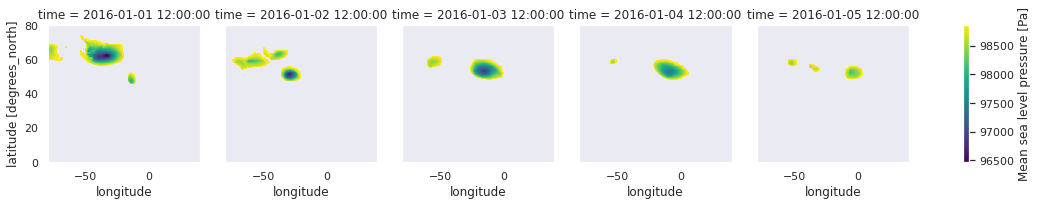

In [ ]:
stormtrack.ds.msl.where(clust < 3).plot(col = "time")

# Examples

In [ ]:
# ds = xr.open_dataset("data/rca_unrot_data_1_5.nc", use_cftime = True)
# ds = ds.rename({"rlon":"lon", "rlat":"lat"})

In [ ]:
ds = xr.open_dataset("data/era5.nc", use_cftime = True).isel(time = slice(0,5))

In [ ]:
stormtrack = storm(ds = ds)
stormtrack.set_up(force = True)

INFO: 
 time: 'time'
 longitude: 'longitude'
 latitude: 'latitude'



In [ ]:
stormtrack = stormdetection(stormtrack, slpname = "msl", pmax = 99000)

  0%|          | 0/5 [00:00<?, ?it/s]

Calculating d/dlon for all time, lat points ...


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating d/dlat for all time, lon points ...


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating d/dlon for all time, lat points ...


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating d/dlat for all time, lon points ...


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


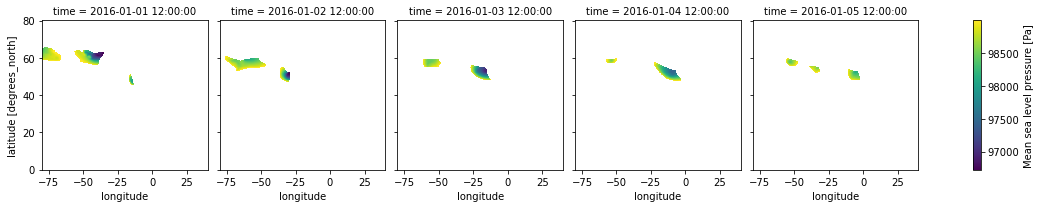

In [ ]:
stormtrack.ds.lows.plot(col = "time", col_wrap = 5)

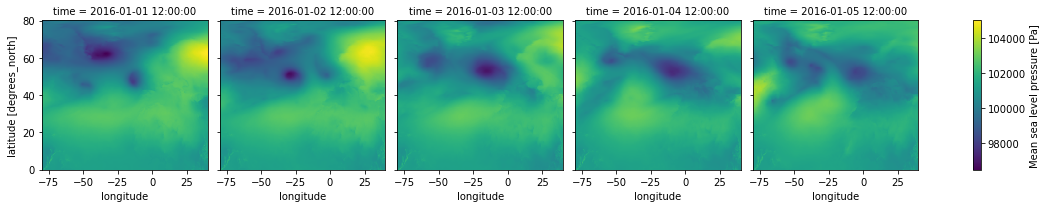

In [ ]:
stormtrack.ds.msl.plot(col = "time", col_wrap = 5)

In [ ]:
da_stacked = stormtrack.ds.lows.isel(time = 0).stack(x=['latitude','longitude']) 
da_stacked[da_stacked.notnull()]

<xarray.DataArray 'lows' (x: 2791)>
array([98971.14 , 98898.26 , 98951.38 , ..., 98494.555, 98513.4  ,
       98531.336], dtype=float32)
Coordinates:
    time       object 2016-01-01 12:00:00
  * x          (x) MultiIndex
  - latitude   (x) float64 45.75 45.75 46.0 46.0 ... 65.25 65.25 65.25 65.25
  - longitude  (x) float64 -14.25 -14.0 -14.75 -14.5 ... -76.75 -76.5 -76.25
Attributes:
    units:          Pa
    long_name:      Mean sea level pressure
    standard_name:  air_pressure_at_mean_sea_level

In [ ]:
def

In [ ]:
from sklearn.cluster import KMeans
n = 20
tmp_clust = stormtrack.ds.msl.isel(time = 0).values.reshape(-1,1)
k_means = KMeans(n_clusters=n, random_state= 0)
_ = k_means.fit(tmp_clust)
X_clustered = k_means.labels_
X_clustered = X_clustered.reshape(stormtrack.ds.msl.isel(time = 0).values.shape)


label_list = [stormtrack.ds.msl.isel(time = 0).values[X_clustered == i].mean() for i in np.arange(0,n)]
mean_sort = np.argsort(np.asarray(label_list))

new = X_clustered.copy().astype(float)

for step, i in enumerate(mean_sort):
    fac = step * 0.1
    new[X_clustered == i] = fac
new = (new * 10).astype(int)

foo = xr.DataArray(new, coords=[stormtrack.ds.latitude, stormtrack.ds.longitude])

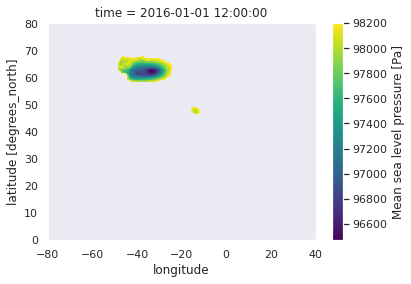

In [ ]:
stormtrack.ds.msl.isel(time = 0).where(foo < 2).plot()

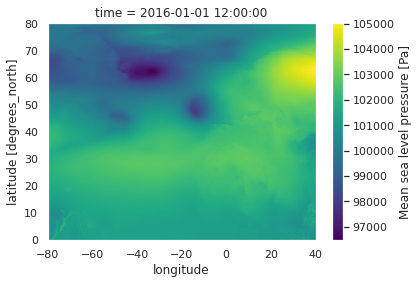

In [ ]:
stormtrack.ds.msl.isel(time = 0).plot()

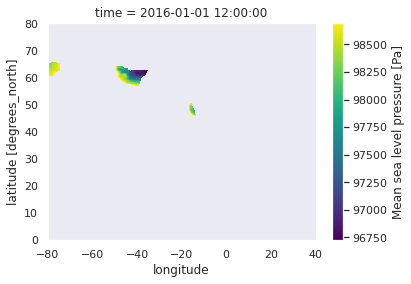

In [ ]:
stormtrack.ds.lows.isel(time = 0).where(foo < 3).plot()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = stormtrack.ds.msl.sel(longitude = -50, method = "nearest").isel(time = 1)
ddata = stormtrack.ds.ddlatitudemsl.sel(longitude = -50, method = "nearest").isel(time = 1)
d2data = stormtrack.ds.d2dlatitudemsl.sel(longitude = -50, method = "nearest").isel(time = 1)

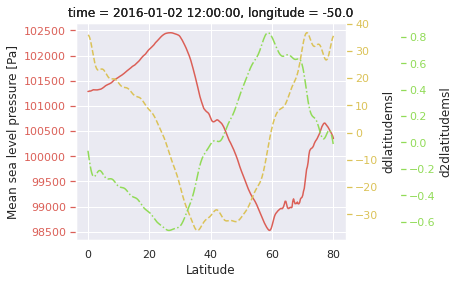

In [ ]:
sns.set()

f, ax = plt.subplots(1)

axes = [ax, ax.twinx(), ax.twinx()]
colors = sns.color_palette("hls", 8)


data.plot(ax = axes[0], color = colors[0])
ddata.plot(ax = axes[1], color = colors[1], ls="--")
d2data.plot(ax = axes[2], color = colors[2], ls="-.")
f.subplots_adjust(right=0.75)
axes[-1].spines['right'].set_position(('axes', 1.2))
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

for ax, color in zip(axes, colors):
    ax.tick_params(axis='y', colors=color)
    ax.grid(False)
axes[0].set_xlabel("Latitude")
axes[0].grid()